In [141]:
cd ~/cg1/Golitzin/SWEMLv2.0/Evaluation

/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/Evaluation


In [142]:
import os
HOME = os.getcwd()
HOME = os.chdir('..')
HOME = os.getcwd()
import shutil 
import numpy as np
import rasterio
import pyproj
from rasterio.plot import show
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import concurrent.futures as cf

from datetime import datetime, date
import geopandas as gpd
import rioxarray as rxr
import contextily as cx
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# from rasterio.plot import plotting_extent
# import earthpy.plot as ep

In [73]:
os.environ['PROJ_LIB'] =pyproj.datadir.get_data_dir() ## figure this out later (4/15)

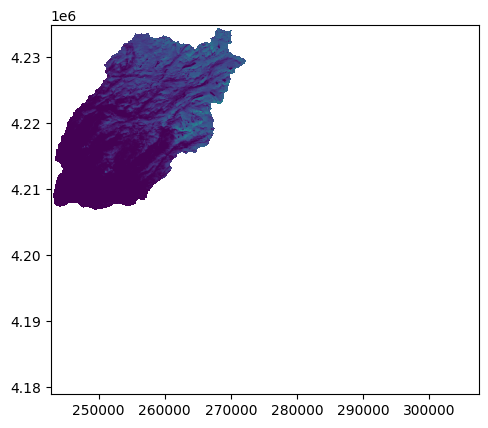

<Axes: >

In [89]:
# just viewing images rlly quick to see what they look like
file = f"{HOME}/../../SWEMLdata/ASO/2016/ASO_50M_SWE_USCACE_20160509.tif" 

tiff = rasterio.open(file)
show(tiff)
# left,bottom,right,top = tiff.bounds

In [4]:
ASO_Key=pd.read_csv(f"{HOME}/../ASOKey.csv",header=3)
ASO_Key.head()

SITE CODE             SITE NAME  Easting  Northing  Easting.1  Northing.1  \
0    USCABI      BISHOP BORESIGHT   373773   4139361   375072.0     4139361   
1    USCABO         USCA_BODIE_GT   323145   4232547   325335.0     4232547   
2    USCABP              BIG PINE   374427   4118148   384804.0     4118148   
3    USCACE        CHERRY ELEANOR   242715   4234848   272748.0     4234848   
4    USCACM  USCA_CHEMUNG_MINE_GT   311901   4247049   312420.0     4247049   

   Easting.2  Northing.2  Easting.3  Northing.3  Unnamed: 10   Longitude  \
0     373773     4137315   375072.0     4137315           11 -118.425986   
1     323145     4230381   325335.0     4230381           11 -119.020405   
2     374427     4110342   384804.0     4110342           11 -118.415014   
3     242715     4206393   272748.0     4206393           11 -119.939137   
4     311901     4246512   312420.0     4246512           11 -119.152633   

   Latitude  Longitude.1  Latitude.1  Longitude.2  Latitude.2  Longitude.3  \
0  37.39243  -118.411315   37.392603  -118.425636    37.37399  -118.410969   
1  38.22354  -118.995401   38.223963  -119.019866    38.20403  -118.994868   
2  37.20136  -118.298109   37.202700  -118.413702    37.13102  -118.296907   
3  38.22485  -119.596397   38.232936  -119.928888    37.96873  -119.587339   
4  38.35186  -119.146697   38.351970  -119.152489    38.34703  -119.146554   

   Latitude.3  
0    37.37417  
1    38.20445  
2    37.13235  
3    37.97674  
4    38.34713

In [7]:
## Plot over basemap to check location

# years = [2020,2021,2022,2023,2024]
years = np.arange(2019,2025)
# years = [2013]
fig_filepath=f"{HOME}/../../SWEMLdata/ASO/Figures"
print(fig_filepath)
if not os.path.exists(fig_filepath):
    os.makedirs(fig_filepath,exist_ok=True)
for year in years:
    filepath = f"{HOME}/../../SWEMLdata/ASO/{year}"
    files = [filename for filename in os.listdir(filepath) if filename.endswith(".tif")]
    # print(files)
    for file in files:
        rds = rxr.open_rasterio(f"{filepath}/{file}")
        rds_4326 = rds.rio.reproject("EPSG:4326")
        rds_4326_masked = rds_4326.where((rds_4326>=0) & (rds_4326<8))
        fig,ax = plt.subplots(1,1,
                              figsize=[12,10]
                             )
        rds_4326_masked.plot(ax=ax, alpha=0.5)
    # fig.colorbar(im, ax=ax)
        cx.add_basemap(ax, 
                   # source="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", 
                   source=cx.providers.USGS.USTopo,
                   crs='EPSG:4326'
                   ) 
        if file[:12] == "ASO_50M_SWE_":
            # print(file[12:18])
            index = ASO_Key['SITE CODE']==file[12:18]
            sitename=(ASO_Key.loc[index,'SITE NAME']).item()
            # print(sitename)
            newfilename = "ASO_" + sitename.replace(" ","_") + file[19:]
            # print(newfilename)
        else:
            newfilename = file
        ax.set_title(newfilename)
        plt.savefig(f"{fig_filepath}/{newfilename}.png",dpi=125)
        plt.close()

/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/../../SWEMLdata/ASO/Figures


In [130]:
## Load ASO image and save basin boundary as shapefile
def get_shapefile(input_filepath,input_file,shp_filepath,ASO_Key):
    date = next(element for element in os.path.splitext(input_file)[0].split("_") if element.startswith('20'))
    if date[4].isnumeric() == False:
        date_singleday = os.path.splitext(date)[0].split("-")[0]
        datetime_object = datetime.strptime(date_singleday, "%Y%b%d")
        date = datetime_object.strftime('%Y%m%d')
        #identify basin from site code if applicable, else identify basin from name
    if input_file[:12] == "ASO_50M_SWE_":
        # print(file[12:18])
        sitecode = input_file[12:18]
        index = ASO_Key['SITE CODE']==sitecode
        sitename=(ASO_Key.loc[index,'SITE NAME']).item().replace(" ","_")
        # print(sitename)
        newfilename = f"ASO_{sitename}_{sitecode}_{date}.shp"
        # print(newfilename)
    else:
        sitename = os.path.splitext(input_file)[0].split("_")[1]
        newfilename = f"ASO_{sitename}_{date}.shp"
    print(newfilename)
        
    with rasterio.open(f"{input_filepath}/{input_file}") as src:
        image = src.read(1)
        mask = image >= 0  # mask zero & nodata values
        results = (
            {'properties': {'value': v}, 'geometry': s}
            for s, v in rasterio.features.shapes(image, mask=mask, transform=src.transform)
        )

        # Convert to GeoDataFrame
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Dissolve into one shape
    dissolved = gdf.dissolve()
    # Reproject to WGS84
    dissolved = dissolved.to_crs(epsg=4326)
    shp_filename = f"{shp_filepath}/{newfilename}"
    dissolved.to_file(shp_filename)

In [166]:
## Multiprocessing ASO images --> shapefiles
years = [2013,2016,2017,2018,2019] ## 2014, 2015 files are not clipped to basins, so leaving out 
# years = [2015]
shp_filepath=f"{HOME}/../../SWEMLdata/ASO/Shapefiles"
print(shp_filepath)
if not os.path.exists(shp_filepath):
    os.makedirs(shp_filepath,exist_ok=True)
    
for year in years:
    filepath = f"{HOME}/../../SWEMLdata/ASO/{year}"
    files = [filename for filename in os.listdir(filepath) if filename.endswith(".tif")]
    # files = [filename for filename in os.listdir(filepath) if filename.startswith("ASO_50M_SWE_USCORG")]
    # print(files)
    # for filename in files:
        # get_shapefile(filepath,filename,shp_filepath,ASO_Key)
    with cf.ProcessPoolExecutor(max_workers=None) as executor: 
        # Start the load operations and mark each future with its process function
        [executor.submit(get_shapefile(filepath,files[i],shp_filepath,ASO_Key)) for i in tqdm(range(len(files)))]

        

/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/../../SWEMLdata/ASO/Shapefiles


  0%|          | 0/2 [00:00<?, ?it/s]

ASO_RIO_GRANDE_RIVER_USCORG_20150407.shp
ASO_RIO_GRANDE_RIVER_USCORG_20150602.shp


<Axes: >

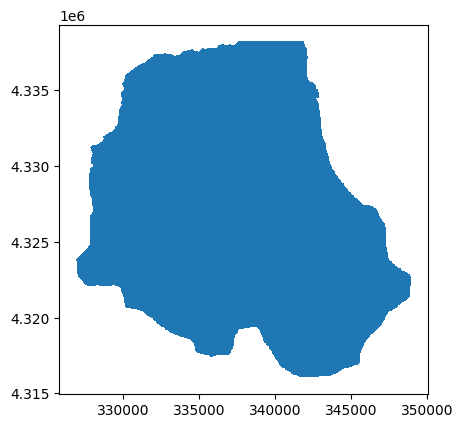

In [118]:
filepath = f"{HOME}/../../SWEMLdata/ASO/{year}"
file = "ASO_50M_SWE_USCOCM_20190407.tif"
year = 2019
with rasterio.open(f"{filepath}/{file}") as src:
    image = src.read(1)
    mask = (image >= 0)  # Create a mask to ignore NoData pixels
    results = (
        {'properties': {'value': v}, 'geometry': s}
        for s, v in rasterio.features.shapes(image, mask=mask, transform=src.transform)
        )

    # Convert to GeoDataFrame
    geoms = list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
    
gdf.plot()

0    3381.780943
dtype: float64
0    POLYGON ((-1005653.768 1694811.169, -1005648.9...
Name: geometry, dtype: geometry


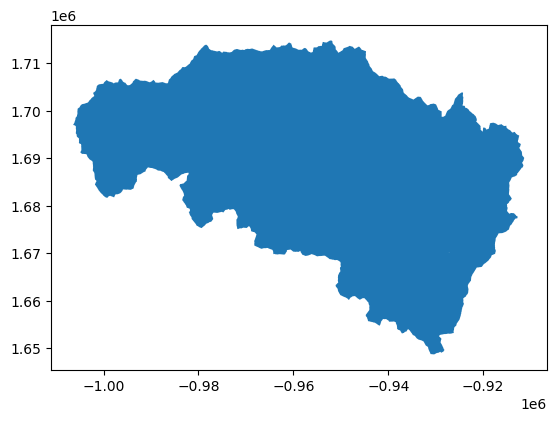

In [173]:
## test plot to see how it looks, calculate area using equal-area projection
shp_filepath=f"{HOME}/../../SWEMLdata/ASO/Shapefiles"
test = gpd.read_file(f'{shp_filepath}/ASO_RIO_GRANDE_RIVER_USCORG_20150602.shp')
test = test.to_crs(epsg=5070)
test_area = test.area/10**6
test.plot()
print(test_area)
print((test.geometry))

In [168]:
# read shapefiles into dataframe by keyword to select by area
vals_list = []
shp_filepath=f"{HOME}/../../SWEMLdata/ASO/Shapefiles"
files = [filename for filename in os.listdir(shp_filepath) if filename.endswith(".shp")]
# print(files)
for file in files:
    # print(os.path.splitext(file)[0].split("_"))
    date = next(element for element in os.path.splitext(file)[0].split("_") if element.startswith('20'))
    site = next(element for element in os.path.splitext(file)[0].split("_") if element.startswith('US'))
    ## the above will obviously only work for filenames that include a site code
    ## need to rework above for 2020-2024 data later, maybe w/ try-except?
    # print(date,site)
    shp = gpd.read_file(f'{shp_filepath}/{file}')
    shp = shp.to_crs(epsg=5070) ## use equal-area projection; this one is CONUS Albers
    shp_area = shp.area/10**6   ## convert from m^2 to km^2
    name_vals = {'filename':file[:-4],'sitecode':site,'area':shp_area[0]}
    vals_list.append(name_vals)
    # print(name_vals)
area_df = pd.DataFrame(vals_list)


In [179]:
area_df[area_df['sitecode']=='USCAMB']

filename sitecode         area
18  ASO_MERCED_RIVER_USCAMB_20180425   USCAMB   883.413972
38  ASO_MERCED_RIVER_USCAMB_20190716   USCAMB  1027.961775
59  ASO_MERCED_RIVER_USCAMB_20190329   USCAMB   834.420283
60  ASO_MERCED_RIVER_USCAMB_20190604   USCAMB  1027.960697
61  ASO_MERCED_RIVER_USCAMB_20190703   USCAMB  1027.960716

In [170]:
## sort shapefiles by area for each basin & pick file with largest area 
## copy to subdirectory

best_shp_filepath = f"{HOME}/../../SWEMLdata/ASO/Shapefiles/BasinShapefiles"
if not os.path.exists(best_shp_filepath):
    os.makedirs(best_shp_filepath,exist_ok=True)
    
sitecodes = area_df['sitecode'].unique()
for site in sitecodes:
    areas=area_df[area_df['sitecode']==site].sort_values(by='area',ascending=False)
    # print(areas)
    # print(areas.iloc[0])
    basin_date = areas.iloc[0]['filename']
    print(basin_date)
    shpfiles = [filename for filename in os.listdir(shp_filepath) if filename.startswith(basin_date)]
    for file in shpfiles:
        src = f"{shp_filepath}/{file}"
        dst = f"{best_shp_filepath}/{file}"
        # print(src,dst)
        shutil.copy(src,dst)

ASO_TUOLUMNE_RIVER_USCATB_20160708
ASO_SAN_JOAQUIN_SOUTH_FORK_USCASF_20190714
ASO_SAN_JOAQUIN_MAIN_FORK_USCASJ_20190704
ASO_TOLUMNE_AND_CHERRYELEANOR_USCATE_20190705
ASO_CHERRY_ELEANOR_USCACE_20170717
ASO_SAN_JOAQUIN_JOSE_WILLOW_USCAJW_20190315
ASO_KINGS_NORTH_USCAKN_20190326
ASO_LAKES_BASIN_USCALB_20160509
ASO_MERCED_RIVER_USCAMB_20190716
ASO_GUNNISON_-_EAST_RIVER_USCOGE_20190407
ASO_GUNNISON_-_TAYLOR_RIVER_USCOGT_20190609
ASO_KINGS_CANYON_USCAKC_20190316
ASO_LEE_VINING_CREEK_USCALV_20170717
ASO_BLUE_RIVER_ABOVE_DILLON_USCOBR_20190624
ASO_RUSH_CREEK_USCARC_20170717
ASO_KAWEAH_RIVER_USCAKW_20190317
ASO_CRESTED_BUTTE_USCOCB_20180330
ASO_RIO_GRANDE_RIVER_USCORG_20150407
ASO_OLYMPIC_MOUNTAINS_USWAOL_20160329
ASO_ASPEN_AND_CASTLE-MAROON_USCOCM_20190610


ASO_TUOLUMNE_RIVER_USCATB_20160708.shp 0    1175.098604
dtype: float64
ASO_SAN_JOAQUIN_SOUTH_FORK_USCASF_20190714.shp 0    974.920379
dtype: float64
ASO_SAN_JOAQUIN_MAIN_FORK_USCASJ_20190704.shp 0    1624.138383
dtype: float64
ASO_TOLUMNE_AND_CHERRYELEANOR_USCATE_20190705.shp 0    1673.08343
dtype: float64
ASO_CHERRY_ELEANOR_USCACE_20170717.shp 0    490.612679
dtype: float64
ASO_SAN_JOAQUIN_JOSE_WILLOW_USCAJW_20190315.shp 0    4232.934748
dtype: float64
ASO_KINGS_NORTH_USCAKN_20190326.shp 0    1352.691962
dtype: float64
ASO_LAKES_BASIN_USCALB_20160509.shp 0    27.781044
dtype: float64
ASO_MERCED_RIVER_USCAMB_20190716.shp 0    1027.961576
dtype: float64
ASO_GUNNISON_-_EAST_RIVER_USCOGE_20190407.shp 0    2386.401365
dtype: float64
ASO_GUNNISON_-_TAYLOR_RIVER_USCOGT_20190609.shp 0    658.356722
dtype: float64
ASO_KINGS_CANYON_USCAKC_20190316.shp 0    3565.385316
dtype: float64
ASO_LEE_VINING_CREEK_USCALV_20170717.shp 0    114.521724
dtype: float64
ASO_BLUE_RIVER_ABOVE_DILLON_USCOBR_201906

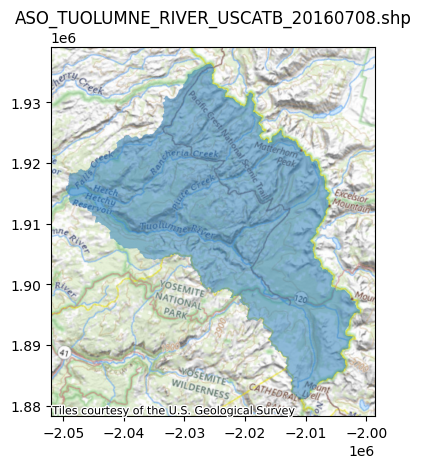

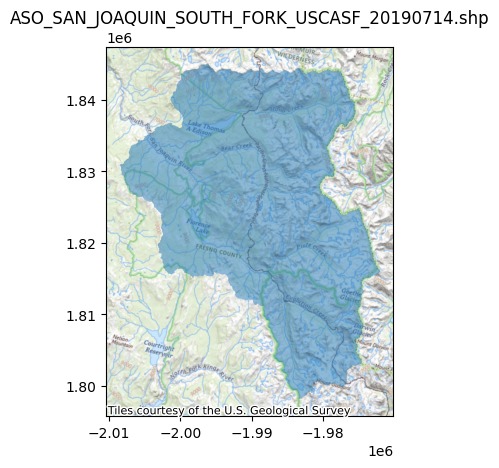

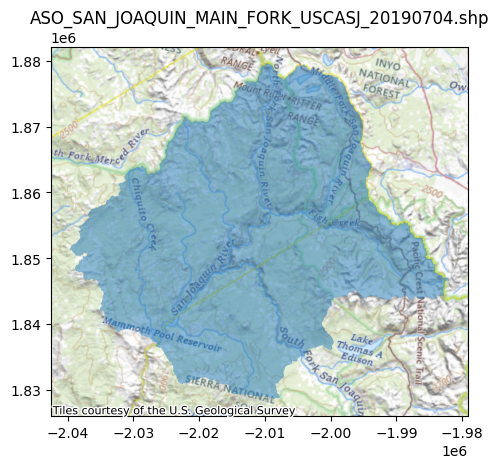

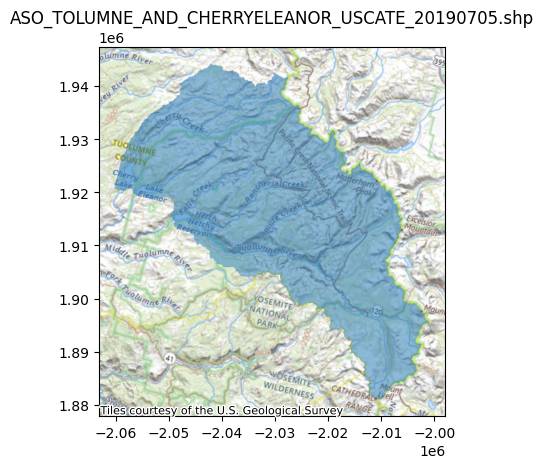

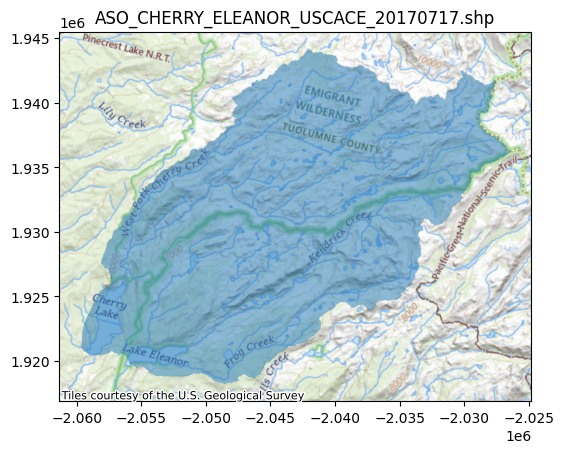

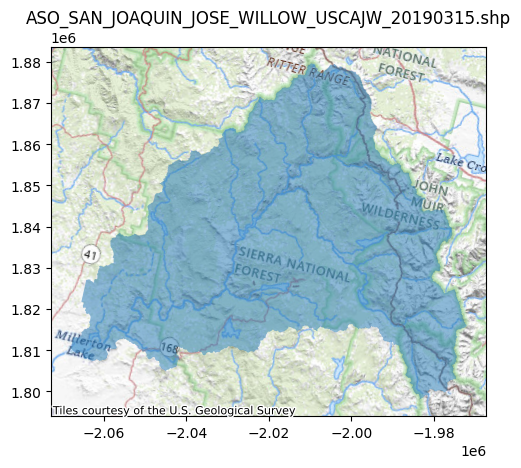

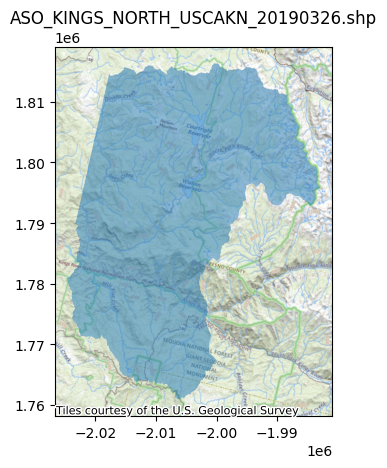

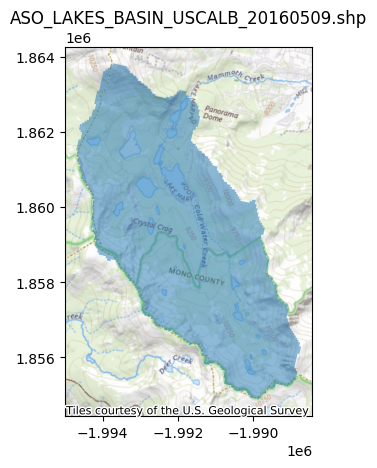

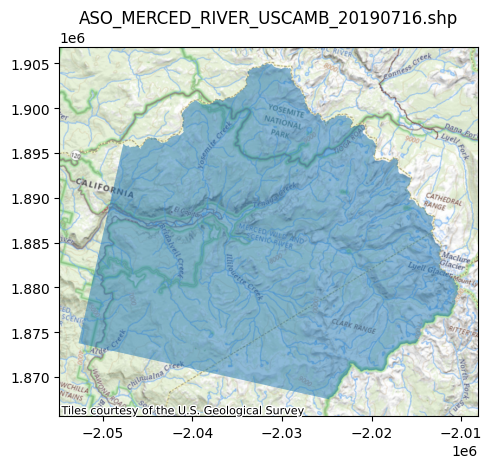

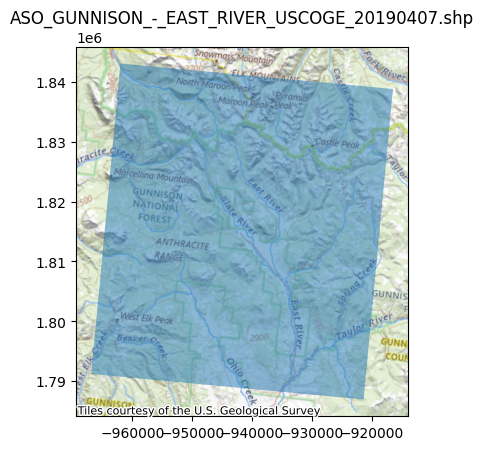

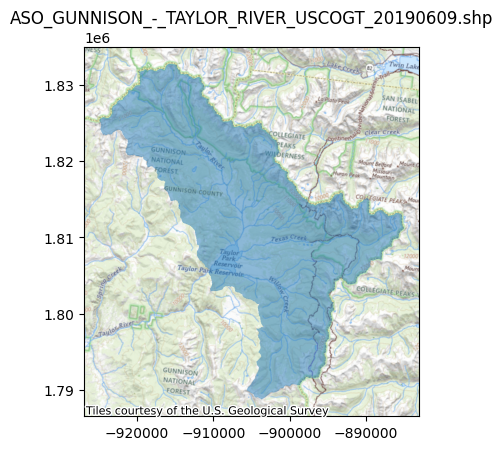

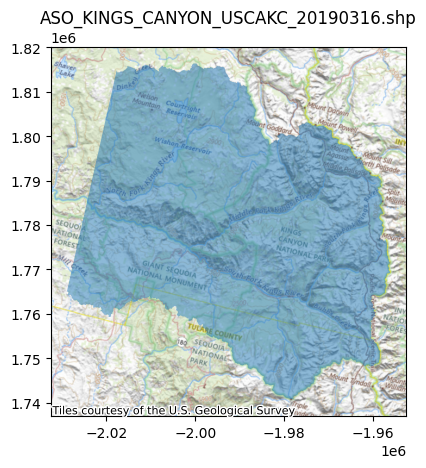

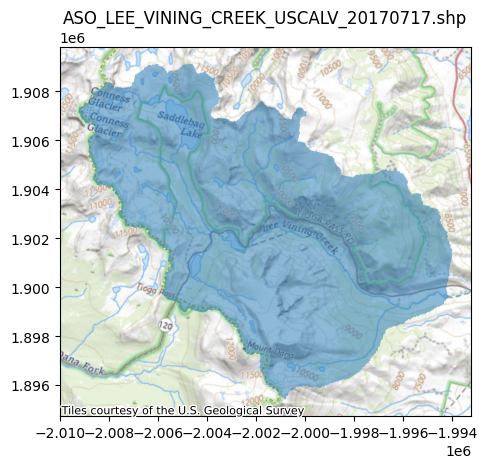

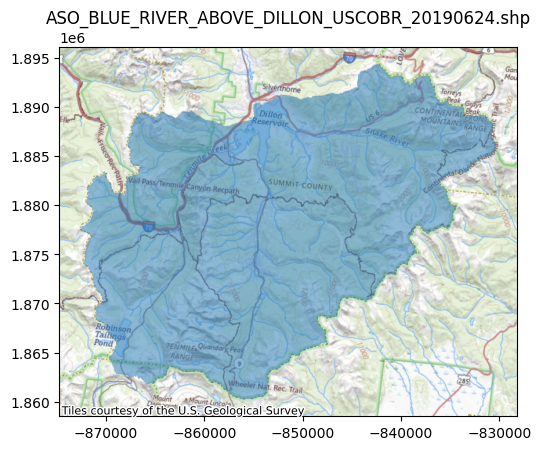

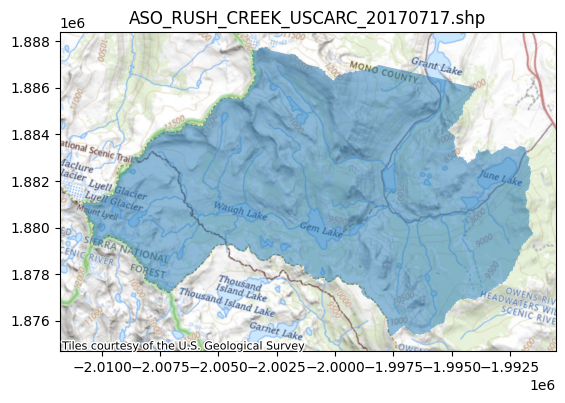

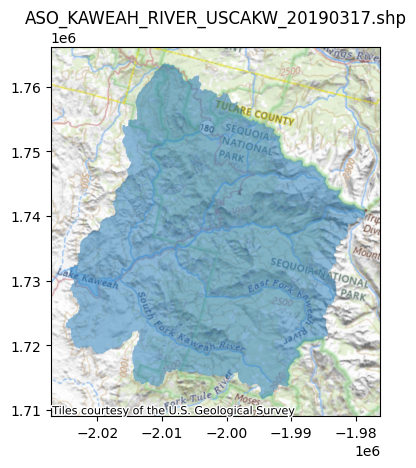

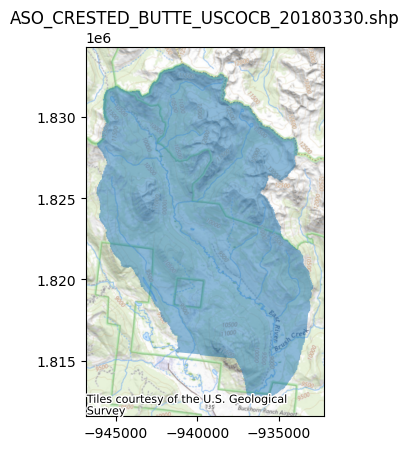

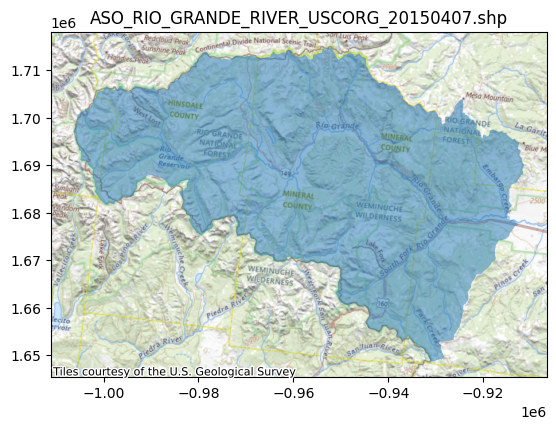

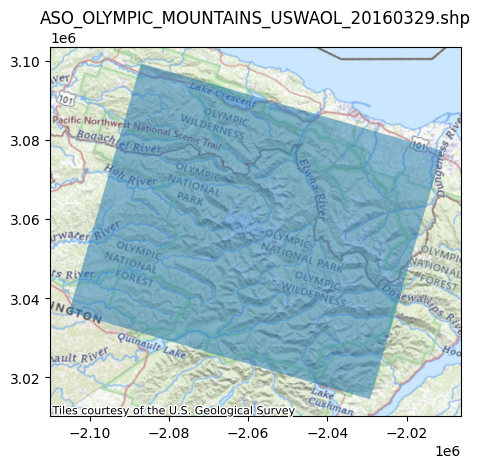

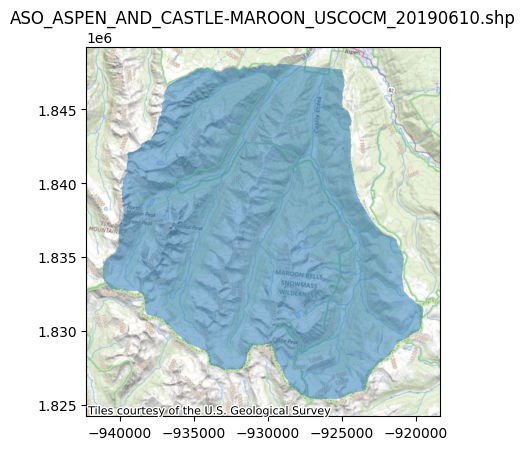

In [178]:
## plot results on basemap to verify shape & location 

bestfiles = [filename for filename in os.listdir(best_shp_filepath) if filename.endswith(".shp")]
for file in bestfiles:
    test = gpd.read_file(f'{best_shp_filepath}/{file}')
    test = test.to_crs(epsg=5070)
    test_area = test.area/10**6
    ax = test.plot(alpha=0.5)
    ax.set_title(file)
    cx.add_basemap(ax,source=cx.providers.USGS.USTopo,
                   crs='EPSG:5070')
    print(file,test_area)